<a href="https://colab.research.google.com/github/rithikgoli/data100-sp20-finalproj/blob/master/Basketball_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [393]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn import preprocessing

In [447]:
import plotly.figure_factory as ff
import requests
import re
from bs4 import BeautifulSoup

In [327]:
official_bs = pd.read_csv('Basketball-BoxScores.csv')
player_bs = pd.read_csv('Basketball-PlayerBoxScore.csv')
standings = pd.read_csv('Standings.csv')
team_bs = pd.read_csv('Basketball-TeamBoxScores.csv')
colleges = pd.read_csv('college.csv')

In [249]:
colleges.head(5)

,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,weight,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240.0,...,0.0,NaN,5.6,0.599,3.3,0.728,2.5,1.8,134.0,8.5
1,1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225.0,...,NaN,NaN,16.8,0.639,10.7,0.628,7.9,5.0,88.0,26.4
3,3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162.0,...,2.7,NaN,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
4,4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We wanted to see how much the game of basketball has changed over the years, so we created a barplot of each team's 3point attempts starting from 2012 up to 2018.  

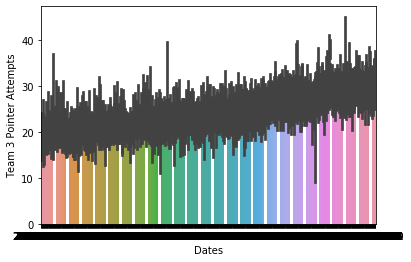

In [387]:
ax = sns.barplot(x = 'gmDate', y = 'team3PA', data=team_bs)
ax.set(xlabel='Dates', ylabel='Team 3 Pointer Attempts')
plt.show()

We can see that over time, the number of 3 pointers attempted increased. The actual dates are hard to see due to the vast number of dates from 2012-2018.

We also wanted to see if there was a correlation between NCAA points scored per game and NBA points scored per game, from a visual standpoint. Therefore, we created a scattorplot mapping those two columns.

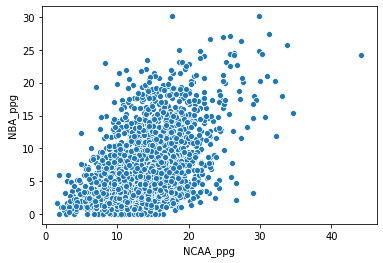

In [453]:
college_ppg = colleges[colleges['NCAA_ppg'].notnull()]
sns.scatterplot(college_ppg["NCAA_ppg"], college_ppg["NBA_ppg"])

From this visualization, we can see there is somewhat of a positive, linear correlation. This scatterplot actually is what gave us motivation for our model down below.

Our next step was to determine how we wanted to sort and clean our data, using EDA. Therefore, we decided to filter out all players that played before the intregation of the 3 point line into the NCAA. Additionally, we know stat-keeping was loosely regulated before the 1980's, so we decided to only include players who played after 1986 in our dataframe.

In [384]:
colleges_Before_1986 = colleges[colleges['active_to'] < 1987]
(colleges_Before_1986['NCAA_ppg'].isnull().sum() / colleges_Before_1986.shape)[0]

0.7929471032745592

From the cell above, we found that almost 80% of players before 1986 did not have their NCAA points per game recorded, which prompted us to remove them from our dataset.

The way we filtered our initial 'Colleges' dataframe was by 
1) only selecting players who began playing college basketball after 1986, 
2) removing all players who didn't score points in college,
3) played at least 82 games, which is equivalent to the length of one NBA season,
4) dropping columns that woulnd't be useful to our model, 
5) and replacing the remaining null values with 0.

In [411]:
colleges_After_1986 = colleges[colleges['active_from'] > 1986]
colleges_After_1986 = colleges_After_1986[colleges_After_1986['NCAA_ppg'].notnull()]
colleges_After_1986 = colleges_After_1986[colleges_After_1986['NBA_g_played'] > 81]
colleges_After_1986 = colleges_After_1986.drop(columns = ['NCAA_efgpct', 'url', 'Unnamed: 0'])
colleges_After_1986 = colleges_After_1986.fillna(0)
colleges_After_1986.head(5)

,active_from,active_to,birth_date,college,height,name,position,weight,NBA__3ptapg,NBA__3ptpct,...,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,240.0,0.0,0.000,...,0.000,0.0,5.6,0.599,3.3,0.728,2.5,1.8,134.0,8.5
3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,162.0,2.3,0.354,...,0.372,2.7,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
5,1997,2008,"December 11, 1976",University of California,6-9,Shareef Abdur-Rahim,F,225.0,0.6,0.297,...,0.381,0.3,14.2,0.518,7.4,0.683,8.9,6.1,28.0,21.1
12,1988,1993,"November 15, 1962",Oral Roberts University,6-11,Mark Acres,F-C,220.0,0.0,0.538,...,0.000,0.0,12.9,0.564,7.3,0.696,5.7,4.0,110.0,18.5
14,2013,2018,"October 6, 1990",Baylor University,6-7,Quincy Acy,F,240.0,1.5,0.355,...,0.429,0.0,6.0,0.602,3.6,0.708,3.6,2.5,139.0,9.8


We tried to standardize our data, but we were running into problems with the fact that standardizing can only be done to integer values. We decided to make a dataframe with columns that only contained integers, but some of the values were above 1 and below 0. So, for the sake of time and other finals we have this week, we decided to not focus on that. We don't use normalized_df anywhere but here. However, once school is over, we definitely want to come back to this and figure it out. 

In [412]:
normalized_df = ((colleges_After_1986[['NBA_g_played', 'NBA_ppg', 'NCAA__3ptapg', 'NCAA__3ptpct',
       'NCAA__3ptpg', 'NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg', 'NCAA_ft',
       'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']])-(colleges_After_1986[['NBA_g_played', 'NBA_ppg', 'NCAA__3ptapg', 'NCAA__3ptpct',
       'NCAA__3ptpg', 'NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg', 'NCAA_ft',
       'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']].mean()))/(colleges_After_1986[['NBA_g_played', 'NBA_ppg', 'NCAA__3ptapg', 'NCAA__3ptpct',
       'NCAA__3ptpg', 'NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg', 'NCAA_ft',
       'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']].std())
normalized_df

,NBA_g_played,NBA_ppg,NCAA__3ptapg,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,-0.657910,-0.550186,-1.068689,-1.805259,-1.015057,-1.511236,1.783304,-1.174737,0.150284,-1.149100,-1.069962,1.110737,-1.337510
3,0.464284,1.457785,2.312674,0.506025,2.265829,3.908428,-0.370293,3.800977,1.715373,1.525352,2.241188,-1.036159,3.884164
5,1.294027,2.247437,-0.692982,0.561944,-0.650514,1.348219,0.387773,1.698563,-0.371413,3.239744,2.778132,-2.140276,1.871909
12,-0.253240,-1.023977,-1.068689,-1.805259,-1.015057,0.915976,1.180297,1.628482,-0.220700,1.045322,0.898830,0.374658,1.209648
14,-0.423269,-0.708116,-1.021726,0.860174,-1.015057,-1.378238,1.834990,-0.964495,-0.081581,-0.394767,-0.443528,1.264086,-1.006379
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4552,-0.681714,-0.527624,0.011468,0.406615,-0.042943,-0.015009,0.043198,0.016631,-0.267073,-0.531918,-0.533019,1.386766,-0.140346
4553,1.260021,1.187048,0.340212,0.798043,0.564629,0.583481,-0.301378,0.507195,0.324182,-1.286251,-1.159453,-2.048266,0.165313
4558,-0.467477,-0.053833,-1.068689,-1.805259,-1.015057,-0.247756,1.662702,0.367034,0.474895,1.662503,1.793735,-0.790799,0.598330
4563,-0.154623,-0.256887,-1.068689,-1.805259,-1.015057,-0.513752,0.818493,-0.193610,0.695167,0.222414,0.451377,0.589348,-0.242232


Now that we had our filtered dataframe, we shuffled all of our data to make a sample and get a permuation of our data.

In [413]:
shuffled_data = colleges_After_1986.sample(frac=1, random_state=24)
shuffled_data

,active_from,active_to,birth_date,college,height,name,position,weight,NBA__3ptapg,NBA__3ptpct,...,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
3547,2013,2016,"June 6, 1989",Gonzaga University,7-0,Robert Sacre,C,270.0,0.0,0.000,...,0.250,0.0,6.0,0.504,3.0,0.735,4.5,3.3,136.0,9.3
148,1992,2002,"August 18, 1969",Arizona State University,6-10,Isaac Austin,C,255.0,0.1,0.176,...,0.000,0.0,10.3,0.559,5.8,0.637,5.4,3.4,61.0,15.0
2555,1996,2003,"July 17, 1972",University of Connecticut,6-7,Donny Marshall,F,230.0,1.1,0.336,...,0.302,0.4,7.4,0.474,3.5,0.791,3.2,2.5,121.0,9.9
3383,1996,1999,"February 6, 1972",Michigan State University,6-1,Shawn Respert,G,195.0,1.7,0.340,...,0.454,2.8,15.1,0.484,7.3,0.857,4.6,3.9,119.0,21.3
146,2009,2018,"November 10, 1987",University of Texas at Austin,6-0,D.J. Augustin,G,183.0,3.3,0.376,...,0.402,1.6,12.2,0.443,5.4,0.808,5.5,4.4,73.0,16.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,1992,2003,"May 22, 1968","University of Houston, New Mexico State Univer...",6-2,Randy Brown,G,190.0,0.2,0.200,...,0.310,0.2,6.8,0.436,3.0,0.703,4.2,3.0,117.0,9.1
1249,2017,2018,"May 4, 1993",University of Florida,6-8,Dorian Finney-Smith,F,220.0,2.5,0.299,...,0.362,1.4,8.7,0.411,3.6,0.657,3.2,2.1,134.0,10.7
693,2005,2014,"June 20, 1983",Stanford University,6-8,Josh Childress,G-F,210.0,0.8,0.329,...,0.335,1.2,10.2,0.438,4.5,0.755,2.8,2.2,86.0,12.3
3481,1997,2000,"August 19, 1973",University of Alabama,6-10,Roy Rogers,F,235.0,0.0,0.500,...,0.000,0.0,5.2,0.517,2.7,0.610,1.6,1.0,102.0,6.4


In the next few cells, we selected a range of rows for our training and test dataset, using the train_test_split function from sklearn.model_selection. We allocated 80% of our data to be in the training set, and the remaining 20% to be in our test set.

In [414]:
tr, te = train_test_split(colleges_After_1986, test_size=0.2, random_state=96)

In [415]:
tr

,active_from,active_to,birth_date,college,height,name,position,weight,NBA__3ptapg,NBA__3ptpct,...,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
43,1996,2005,"June 22, 1973",University of Virginia,6-1,Cory Alexander,G,185.0,2.2,0.354,...,0.336,1.7,12.6,0.427,5.4,0.693,3.8,2.7,85.0,15.1
97,1997,2006,"December 31, 1973",University of Georgia,6-6,Shandon Anderson,F-G,208.0,1.4,0.316,...,0.291,0.4,9.9,0.498,4.9,0.634,4.1,2.6,118.0,12.9
2077,1999,2000,"July 17, 1975","Rutgers University, Long Island University",6-3,Charles Jones,G,180.0,2.1,0.324,...,0.352,3.0,19.7,0.429,8.4,0.640,4.0,2.5,108.0,22.5
3584,2002,2012,"March 18, 1978",University of Southern California,6-9,Brian Scalabrine,F,241.0,1.0,0.344,...,0.343,0.5,11.2,0.513,5.7,0.770,4.8,3.7,92.0,15.7
307,1996,2005,"July 12, 1972",Georgia Institute of Technology,5-11,Travis Best,G,182.0,1.1,0.345,...,0.393,2.1,12.4,0.456,5.7,0.809,3.9,3.2,124.0,16.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2004,2017,"March 9, 1980","University of California, Los Angeles",6-7,Matt Barnes,F,226.0,3.2,0.335,...,0.314,0.5,7.1,0.469,3.3,0.566,2.9,1.7,121.0,8.8
2333,2001,2004,"November 28, 1977",Vanderbilt University,6-11,Dan Langhi,F,220.0,0.3,0.289,...,0.383,1.1,9.0,0.445,4.0,0.831,3.9,3.3,121.0,12.4
1337,1998,2005,"December 15, 1970","Indiana University, Ohio State University",6-9,Lawrence Funderburke,F,230.0,0.1,0.118,...,0.300,0.0,11.2,0.538,6.0,0.613,4.0,2.5,86.0,14.5
3856,1989,2002,"August 10, 1965",Oklahoma State University,6-3,John Starks,G,180.0,4.1,0.340,...,0.380,1.4,10.3,0.497,5.1,0.838,4.5,3.8,30.0,15.4


In [416]:
te

,active_from,active_to,birth_date,college,height,name,position,weight,NBA__3ptapg,NBA__3ptpct,...,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
748,2002,2014,"December 2, 1978",Stanford University,7-0,Jason Collins,C,255.0,0.0,0.206,...,0.444,0.2,5.9,0.612,3.6,0.716,4.8,3.4,73.0,10.8
3779,1996,2011,"July 26, 1975",University of Maryland,6-10,Joe Smith,F,225.0,0.1,0.238,...,0.423,0.2,12.8,0.551,7.0,0.738,8.0,5.9,64.0,20.2
1211,2011,2018,"July 15, 1991",Georgia Institute of Technology,6-10,Derrick Favors,F-C,265.0,0.2,0.188,...,0.000,0.0,8.1,0.611,5.0,0.629,4.0,2.5,36.0,12.4
2840,1992,1997,"December 28, 1965",University of Tulsa,6-4,Tracy Moore,G-F,200.0,1.9,0.344,...,0.454,1.3,12.7,0.461,5.8,0.733,3.8,2.8,121.0,15.1
2247,1991,1999,"March 6, 1967",University of Dayton,6-1,Negele Knight,G,175.0,0.3,0.263,...,0.425,1.0,11.0,0.469,5.2,0.746,5.0,3.7,122.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3867,2011,2018,"September 5, 1990",University of Cincinnati,6-5,Lance Stephenson,G-F,230.0,2.0,0.304,...,0.219,0.5,10.8,0.440,4.8,0.664,3.5,2.3,34.0,12.3
1219,1987,1992,"June 8, 1962",University of Texas at El Paso,6-11,Dave Feitl,C,235.0,0.0,0.000,...,0.000,0.0,8.7,0.501,4.3,0.731,3.9,2.8,125.0,11.5
2780,1994,2003,"January 25, 1970","University of Kentucky, University of Arizona",6-6,Chris Mills,F,215.0,2.2,0.351,...,0.375,1.1,12.4,0.508,6.3,0.767,3.6,2.7,126.0,16.5
4102,1987,1992,"December 13, 1964",University of Memphis,5-11,Andre Turner,G,160.0,0.3,0.237,...,0.000,0.0,9.1,0.487,4.4,0.757,2.7,2.1,132.0,10.9


Now that we have the training and test datasets, we want to create a model. In our model, we want to determine whether  college players NCAA statistics will predict their NBA points scored per game. We decided to use a linear regression model, and used the sklearn Pipelines package to combine our features and model. The features we included were NCAA 3 pointers attempted per game, 3 point percentage per game, field goals attempted per game, field goal percentage, field goalds made per game, free throws attempted per game, games played, and points scored per game.

In [417]:
qualitative_features = ['NCAA__3ptapg', 'NCAA__3ptpct', 'NCAA__3ptpg', 'NCAA_fgapg', 
                        'NCAA_fgpct', 'NCAA_fgpg', 'NCAA_ft','NCAA_ftapg', 
                        'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']
model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ('keep', 'passthrough', qualitative_features)])),
    ('LinearModel', LinearRegression())
])

Then, we fit the entire pipeline to our NBA points per game column from our training dataset.

In [439]:
model.fit(tr, tr['NBA_ppg'])

Pipeline(memory=None,
         steps=[('SelectColumns',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('keep', 'passthrough',
                                                  ['NCAA__3ptapg',
                                                   'NCAA__3ptpct',
                                                   'NCAA__3ptpg', 'NCAA_fgapg',
                                                   'NCAA_fgpct', 'NCAA_fgpg',
                                                   'NCAA_ft', 'NCAA_ftapg',
                                                   'NCAA_ftpg', 'NCAA_games',
                                                   'NCAA_ppg',
                                                   'top_25_colleges'])],
                                   verbose=False)),
                ('LinearModel',
                 Line

In order to test our model and evaluate the error, we used the Root Mean Squared Error formula.

In [436]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

Here, we made predictions on the entire DataFrame and the error of our model on the training data.
The first cell calculates the RMSE with the mean of our NBA ppg from our training data.
The second cell calculates the RMSE with predicted values of our training data.

In [446]:
rmse(tr['NBA_ppg'], np.mean(tr['NBA_ppg']))
print("Training Error (RMSE):", rmse(tr['NBA_ppg'], np.mean(tr['NBA_ppg'])))

Training Error (RMSE): 4.564299652908435


In [442]:
Y_hat = model.predict(tr)
Y = tr['NBA_ppg']
print("Training Error (RMSE):", rmse(Y, Y_hat))

Training Error (RMSE): 3.827488890085125


After running our RMSE formula on our training data, we got an error of 3.916. There is a clear decrease in our RMSE from the first cell to the second cell, which highlights the importance of predicting our training data. We went from our baseline of 4.564 to 3.827.

We wanted to test the accuracy of the training error to ensure that this isn't an outlier. Therefore, we used the sklearn KFold cross validation class to run test our error 5 times with different data splits.

In [421]:
def cross_validate_rmse(model):
    model = clone(model)
    five_fold = KFold(n_splits = 5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(tr):
        model.fit(tr.iloc[tr_ind,:], tr['NBA_ppg'].iloc[tr_ind])
        rmse_values.append(rmse(tr['NBA_ppg'].iloc[va_ind], model.predict(tr.iloc[va_ind,:])))
    return np.mean(rmse_values)

In [422]:
cross_validate_rmse(model)

3.9895657701531335

The error we got from the cross validation rmse formula was 3.989, similar to our previous RMSE of 3.916.

Now that we tested it once, we wanted to add more features to determine whether we could bring our RMSE down. We wanted to see whether players who attended the top 25 colleges, in terms of players who went to the NBA from that school, scored more points than their counterparts. So, we grouped by colleges and sorted from greatest to least. 


One limitation is that we do not check for whether a player attended multiple schools. In these cases, they might not get counted for a school that they actually attended. For example, if a player went to both University of Kentucky and University of Washington, they wouldn't be counted for either.

In [423]:
top_25_colleges = colleges_After_1986['college'].value_counts().sort_values(ascending=False)[:25]
top_25_colleges = np.asarray(top_25_colleges.index[:25])
top_25_colleges

array(['University of Kentucky', 'Duke University',
       'University of North Carolina',
       'University of California, Los Angeles', 'University of Kansas',
       'University of Connecticut', 'University of Arizona',
       'University of Michigan', 'Michigan State University',
       'Georgia Institute of Technology', 'Georgetown University',
       'Syracuse University', 'University of Alabama',
       'University of Memphis', 'University of Florida',
       'Louisiana State University', 'University of Maryland',
       'University of Washington', 'University of Texas at Austin',
       'University of Louisville', 'Indiana University',
       'University of Nevada, Las Vegas', 'Wake Forest University',
       'Stanford University', 'North Carolina State University'],
      dtype=object)

These are the top 25 schools, with the University of Kentucky sending the most players to the NBA, followed by Duke University, specifically within the players from our dataframe.

However, since this is considered to be categorical data, we decided to use one-hot encoding on our Top 25 colleges. The function below, top_25_or_not, accomplishes this goal. For players who attended a top 25 school, they were assigned a value of 1, and the remaining players were assigned a 0.

In [424]:
def top_25_or_not(df):
    top_25 = []
    for i in range(len(df)):
        if df.reset_index()['college'][i] in top_25_colleges:
            top_25.append(1)
        else:
            top_25.append(0)
    return top_25

In [425]:
tr['top_25_colleges'] = top_25_or_not(tr)
te['top_25_colleges'] = top_25_or_not(te)
tr.head(10)

,active_from,active_to,birth_date,college,height,name,position,weight,NBA__3ptapg,NBA__3ptpct,...,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg,top_25_colleges
43,1996,2005,"June 22, 1973",University of Virginia,6-1,Cory Alexander,G,185.0,2.2,0.354,...,1.7,12.6,0.427,5.4,0.693,3.8,2.7,85.0,15.1,0
97,1997,2006,"December 31, 1973",University of Georgia,6-6,Shandon Anderson,F-G,208.0,1.4,0.316,...,0.4,9.9,0.498,4.9,0.634,4.1,2.6,118.0,12.9,0
2077,1999,2000,"July 17, 1975","Rutgers University, Long Island University",6-3,Charles Jones,G,180.0,2.1,0.324,...,3.0,19.7,0.429,8.4,0.640,4.0,2.5,108.0,22.5,0
3584,2002,2012,"March 18, 1978",University of Southern California,6-9,Brian Scalabrine,F,241.0,1.0,0.344,...,0.5,11.2,0.513,5.7,0.770,4.8,3.7,92.0,15.7,0
307,1996,2005,"July 12, 1972",Georgia Institute of Technology,5-11,Travis Best,G,182.0,1.1,0.345,...,2.1,12.4,0.456,5.7,0.809,3.9,3.2,124.0,16.6,1
3669,1989,2003,"March 22, 1966","Saint Mary's College of California, University...",6-6,Brian Shaw,G,190.0,1.5,0.304,...,0.7,8.9,0.434,3.9,0.728,2.6,1.9,100.0,10.1,0
235,1998,2012,"February 11, 1976",Texas Tech University,6-11,Tony Battie,C-F,230.0,0.1,0.162,...,0.1,7.7,0.545,4.2,0.649,3.3,2.1,87.0,10.7,0
4431,2010,2017,"September 14, 1986",Virginia Military Institute,6-6,Reggie Williams,F,205.0,2.6,0.365,...,1.8,16.7,0.498,8.3,0.703,6.3,4.4,112.0,22.8,0
2612,2014,2016,"June 12, 1991",University of Detroit Mercy,6-3,Ray McCallum,G,190.0,1.4,0.335,...,1.0,11.5,0.465,5.4,0.723,5.8,4.2,102.0,15.9,0
2929,2015,2018,"July 14, 1991",University of Connecticut,6-1,Shabazz Napier,G,175.0,2.3,0.363,...,1.8,10.1,0.411,4.2,0.813,4.4,3.6,143.0,13.7,1


If you scroll to the rightmost column, you can see the top_25_colleges column, which has the 0 or 1 values we assigned.

In [426]:
qualitative_features.append('top_25_colleges')

Following this, we created a new model that included our top 25 college feature, to determine whether that had any affect on lowering our RMSE.

In [427]:
model1 = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ('keep', 'passthrough', qualitative_features)])),
    ('LinearModel', LinearRegression())
])

We fit the entire pipeline to our NBA points per game column from our training dataset.

In [428]:
model1.fit(tr, tr['NBA_ppg'])

Pipeline(memory=None,
         steps=[('SelectColumns',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('keep', 'passthrough',
                                                  ['NCAA__3ptapg',
                                                   'NCAA__3ptpct',
                                                   'NCAA__3ptpg', 'NCAA_fgapg',
                                                   'NCAA_fgpct', 'NCAA_fgpg',
                                                   'NCAA_ft', 'NCAA_ftapg',
                                                   'NCAA_ftpg', 'NCAA_games',
                                                   'NCAA_ppg',
                                                   'top_25_colleges'])],
                                   verbose=False)),
                ('LinearModel',
                 Line

In [429]:
Y_hat = model1.predict(tr)
Y = tr['NBA_ppg']
print("Training Error (RMSE):", rmse(Y, Y_hat))

Training Error (RMSE): 3.827488890085125


Here, we made predictions on the entire DataFrame and the error of our model on the training data. After running our RMSE formula, we got an error of 3.827.

In [430]:
cross_validate_rmse(model1)

3.8962146167805045

When we ran our cross validation rmse formula, we got an error of 3.896, which is pretty close to our training RMSE of 3.827.

In [431]:
Y_hat = model1.predict(te)
Y = te['NBA_ppg']
print("Training Error (RMSE):", rmse(Y, Y_hat))

Training Error (RMSE): 3.62570009048892


When running our RMSE formula against our test dataset, we got an error of 3.626.

Overall, after creating our Linear Regression Model and including various features, we decreased our Root Mean Squared Error from our baseline of 4.564 to 3.896. This is a 14.64% decrease overall. However, there are definitely many more features we can test to improve our model and reduce our error.

# Bonus!

We attempted to scrape Player Efficiency Rating (PER) from the Basketball Reference website.

In [448]:
colleges.head()

,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,weight,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240.0,...,0.0,NaN,5.6,0.599,3.3,0.728,2.5,1.8,134.0,8.5
1,1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225.0,...,NaN,NaN,16.8,0.639,10.7,0.628,7.9,5.0,88.0,26.4
3,3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162.0,...,2.7,NaN,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
4,4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's make sure that every player has a valid URL that we can use to look them up on the bballreference website.

In [449]:
colleges["url"].isnull().sum()


0

Now let's get a series of every bball-reference URL that we can use to access the player's page.



In [450]:
urls = 'https://www.basketball-reference.com' + colleges["url"]
urls

0       https://www.basketball-reference.com/players/a...
1       https://www.basketball-reference.com/players/a...
2       https://www.basketball-reference.com/players/a...
3       https://www.basketball-reference.com/players/a...
4       https://www.basketball-reference.com/players/a...
                              ...                        
4571    https://www.basketball-reference.com/players/z...
4572    https://www.basketball-reference.com/players/z...
4573    https://www.basketball-reference.com/players/z...
4574    https://www.basketball-reference.com/players/z...
4575    https://www.basketball-reference.com/players/z...
Name: url, Length: 4576, dtype: object

Let's try to get Kareem Abdul Jabbar's career PER. From manually going on the website, we know it is 24.6 The following code obtains an array of all PERs listed on Abdul Jabbar's Basketball Reference page.



In [451]:
kareem = requests.get(urls[2]) #2 is Kareem's index in the dataframe
kareemysoup = BeautifulSoup(kareem.text, 'html.parser')
kareemresults = re.findall(
    '<td class="right " data-stat="per" >([0-9]*\.[0-9])</td>', kareemysoup.prettify()) #look up PER values
        
kareemresults

['22.5',
 '24.4',
 '25.3',
 '23.4',
 '23.6',
 '21.3',
 '22.9',
 '22.7',
 '17.9',
 '15.8',
 '12.9',
 '24.6',
 '23.4',
 '26.7',
 '17.7',
 '21.9',
 '22.4',
 '20.1',
 '22.8',
 '24.0',
 '22.1',
 '21.2',
 '19.4',
 '13.8',
 '11.9',
 '23.0',
 '22.0',
 '25.5']

While we could manually select 24.6 from this array, from this approach there is unfortunately not an apparent way to select a career PER value in a manner which will be consistent for all player's in the dataset. Therefore, we instead choose to focus on predicting scoring in the NBA rather than a more holistic stat like PER.